In [1]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ✅ Load and clean data
df = pd.read_csv('../../data/downloads/freight_model_output_20250428_235909.csv')
df = df.drop_duplicates(subset='invoice_id', keep='first')
df.columns


Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

## Distribution of rates

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


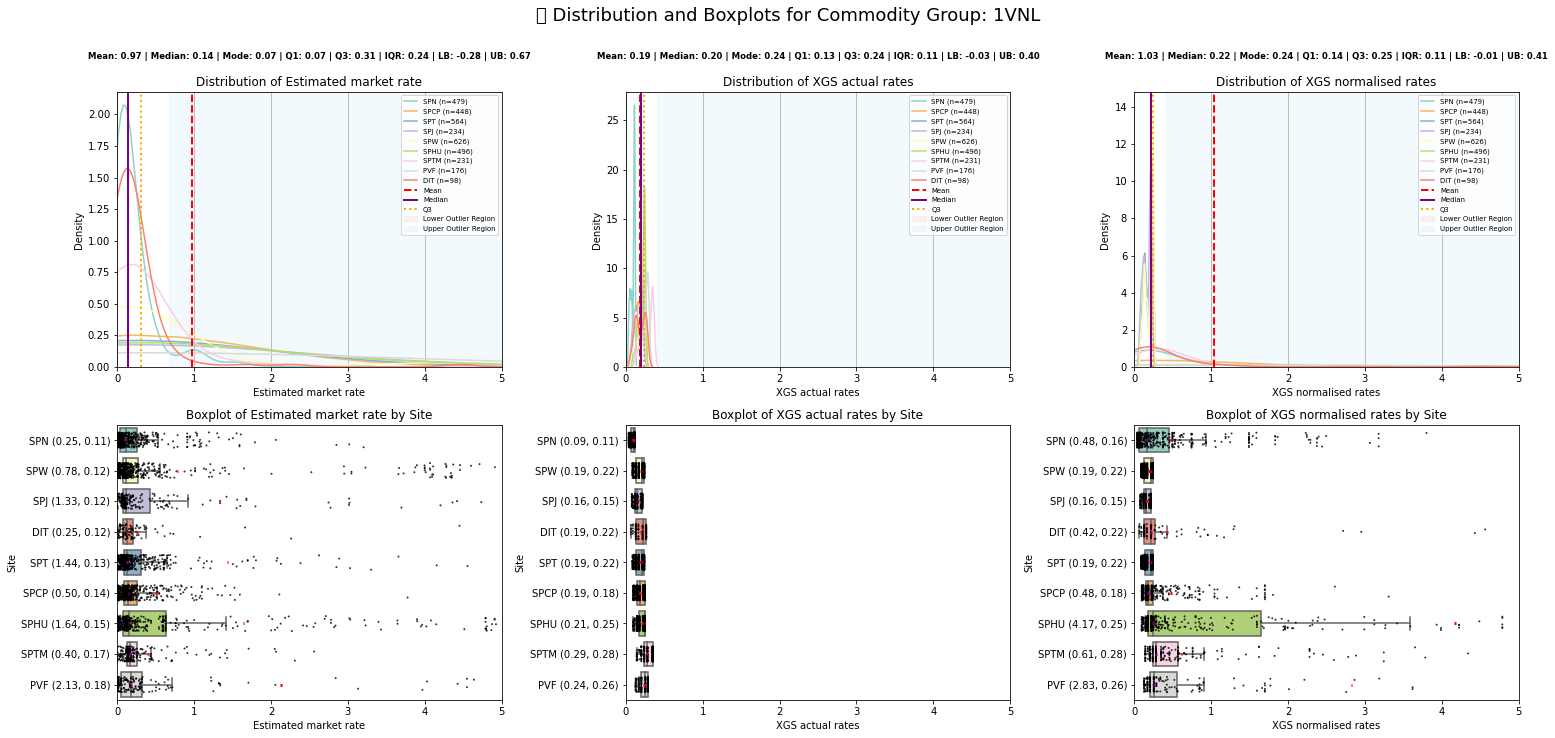

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


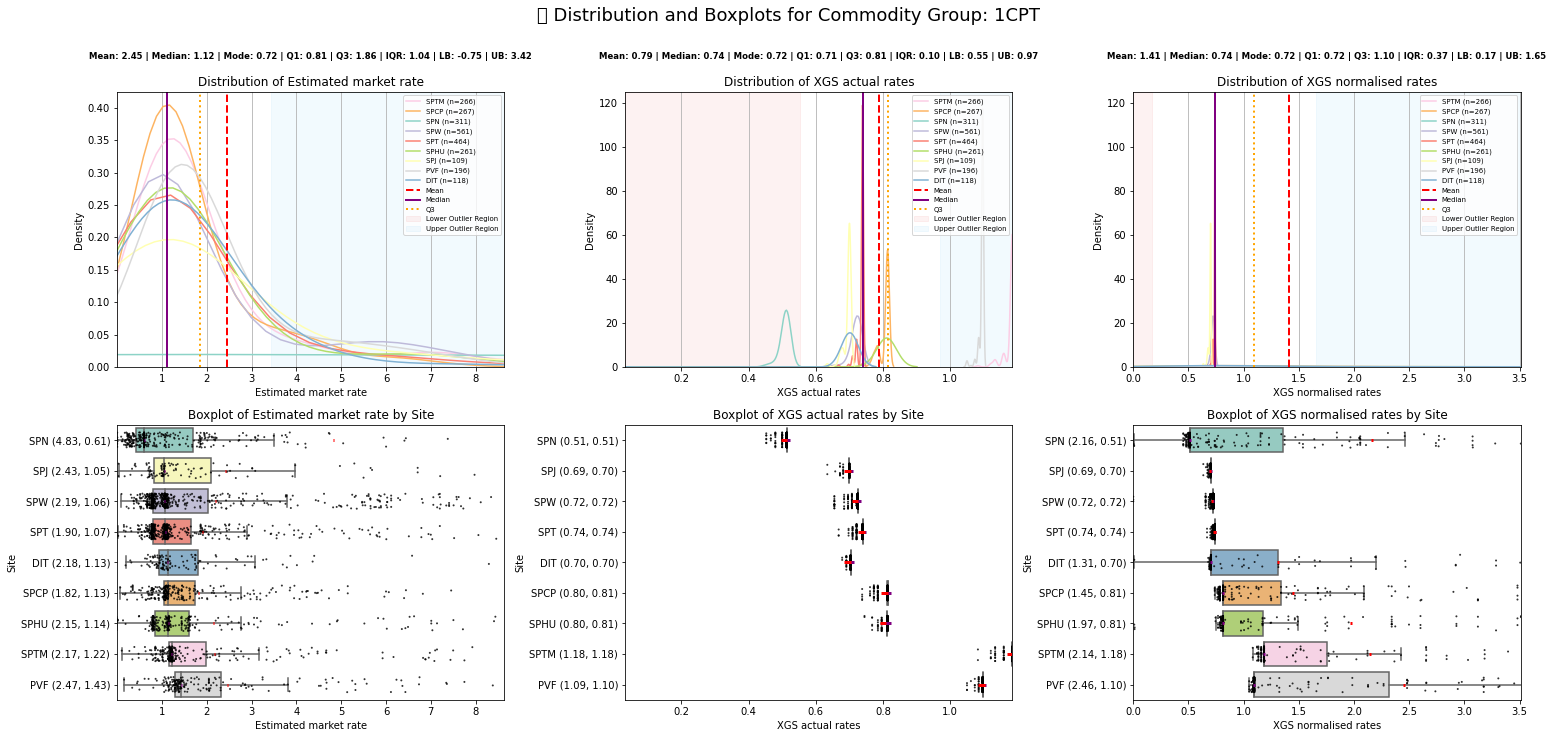

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


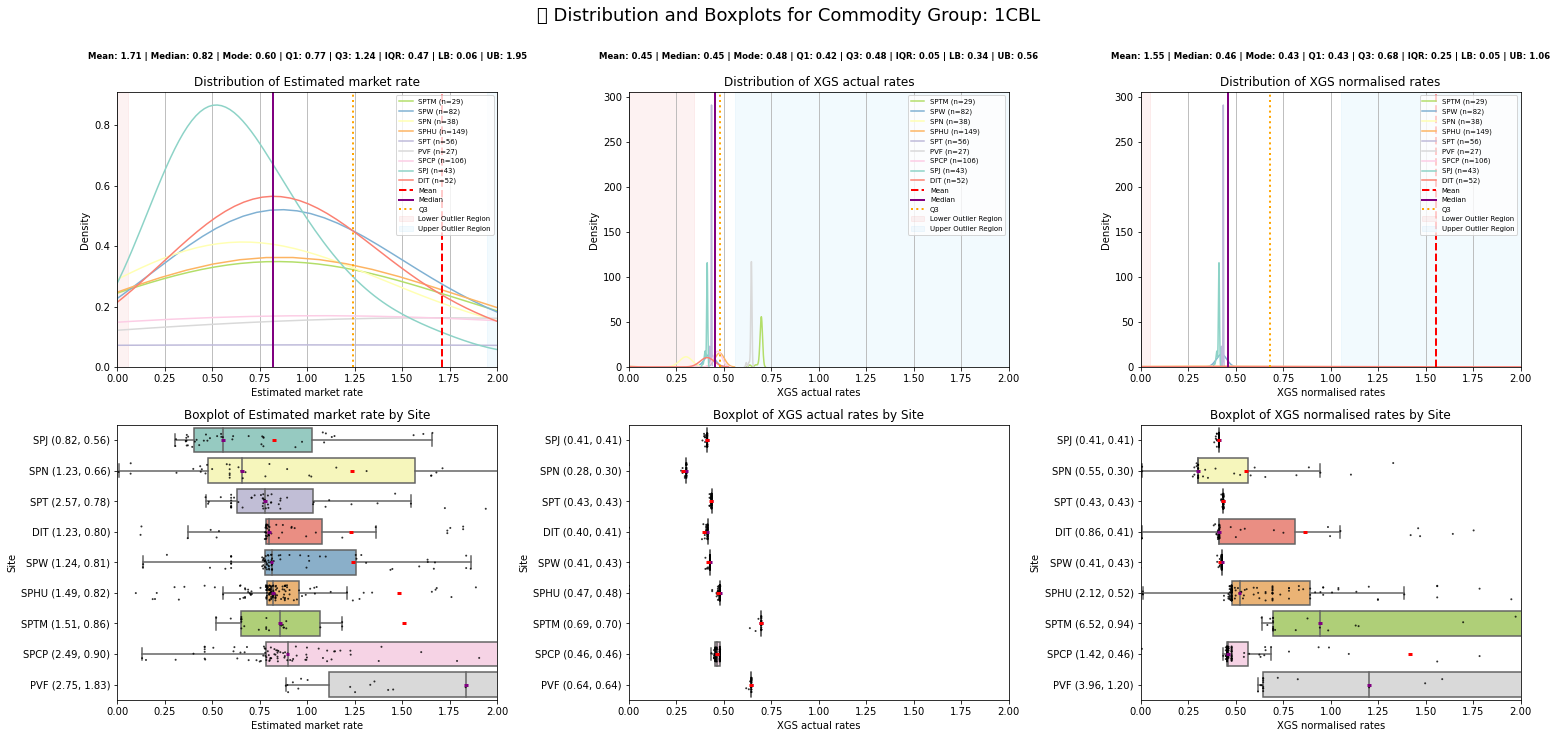

In [4]:
#df = df.drop_duplicates(subset='invoice_id', keep='first')
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.dropna(subset=["market_rate", "xgs_raw_rate",], inplace=True)
df = df[df['calibrated_market_freight_costs'] > 0]

# 📊 Define metrics and visuals
metrics = ["market_rate", "xgs_raw_rate",'xgs_applied_rate']
titles = ["Estimated market rate", "XGS actual rates","XGS normalised rates"]
colors = ["navy", "maroon", "steelblue", "darkorange"]

# 🔁 Loop by commodity group
commodity_groups = df['new_commodity_group'].dropna().unique()

for group in commodity_groups:
    group_df = df[df['new_commodity_group'] == group]

    # 🔁 Sort sites once by market_rate median
    market_sorted = (
        group_df.dropna(subset=["market_rate", "site"])
        .groupby("site")["market_rate"]
        .median()
        .sort_values()
        .index.tolist()
    )
    # 🎨 Assign fixed color per site for visual consistency
    site_palette = dict(zip(
    market_sorted,
    sns.color_palette("Set3", n_colors=len(market_sorted))
))

    fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    fig.subplots_adjust(hspace=0.75, wspace=0.3)
    fig.suptitle(f"📦 Distribution and Boxplots for Commodity Group: {group}", fontsize=18, y=1.02)

    for i, metric in enumerate(metrics):
        ax_top = axes[0, i]
        ax_bottom = axes[1, i]
        data = group_df[metric].dropna()

        # 📊 Summary statistics
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group_mean = data.mean()
        group_mode = data.mode().iloc[0] if not data.mode().empty else None

        # 🔢 Fixed or smart zoom per group
        group_str = str(group).strip().replace("[", "").replace("]", "").replace("'", "")
        if group_str == "1VNL":
            x_range = (0, 5)
        elif group_str == "1CBL":
            x_range = (0, 2)
        else:
            margin = 5 * iqr
            x_min = max(lower_bound - margin, data.min())
            x_max = min(upper_bound + margin, data.max())
            x_range = (x_min, x_max)

        # 📈 KDEs by site
        for site in group_df['site'].dropna().unique():
            site_subset = group_df[group_df['site'] == site]
            site_subset_valid = site_subset[site_subset[metric].notna()]
            site_data = site_subset_valid[metric]
            unique_invoices = site_subset_valid['invoice_id'].nunique()

            if len(site_data) > 1:
                sns.kdeplot(
    site_data,
    ax=ax_top,
    label=f"{site} (n={unique_invoices})",
    linewidth=1.5,
    color=site_palette.get(site, "gray")
)


        # 🔶 Shade outlier regions
        ax_top.axvspan(x_range[0], lower_bound, color='lightcoral', alpha=0.1, label='Lower Outlier Region')
        ax_top.axvspan(upper_bound, x_range[1], color='lightskyblue', alpha=0.1, label='Upper Outlier Region')

        # 📍 Vertical lines
        ax_top.axvline(group_mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(q2, color='purple', linestyle='-', linewidth=2, label='Median')
        ax_top.axvline(q3, color='orange', linestyle=':', linewidth=2, label='Q3')

        # 📝 Summary annotation
        stats_text = (
            f"Mean: {group_mean:.2f} | Median: {q2:.2f} | "
            f"Mode: {group_mode:.2f} | Q1: {q1:.2f} | Q3: {q3:.2f} | "
            f"IQR: {iqr:.2f} | LB: {lower_bound:.2f} | UB: {upper_bound:.2f}"
        )
        ax_top.text(
            0.5, 1.12, stats_text,
            transform=ax_top.transAxes,
            ha='center',
            fontsize=8.5,
            color='black',
            fontweight='bold'
        )

        # 📐 Apply axis range
        ax_top.set_xlim(x_range)
        ax_bottom.set_xlim(x_range)
        ax_top.set_title(f"Distribution of {titles[i]}")
        ax_top.set_xlabel(titles[i])
        ax_top.set_ylabel("Density")
        ax_top.grid(axis='y', visible=False)
        ax_top.grid(axis='x', visible=True)
        ax_top.legend(fontsize="x-small", loc='upper right')

        # 📦 Boxplot + Stripplot (consistent sorting by market_rate)
        plot_data = group_df.dropna(subset=[metric, "site"])
        # 🔁 Build axis labels with (median, mean)
        y_labels = []
        for site in market_sorted:
            site_data = group_df[group_df["site"] == site][metric].dropna()
            if site_data.empty:
                y_labels.append(site)
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()
            label = f"{site} ({mean_val:.2f}, {median_val:.2f})"
            y_labels.append(label)


        sns.boxplot(
            data=plot_data,
            x=metric,
            y="site",
            ax=ax_bottom,
            palette=site_palette,
            fliersize=0,
            order=market_sorted
        )

        sns.stripplot(
            data=plot_data,
            x=metric,
            y="site",
            dodge=True,
            jitter=0.25,
            alpha=0.8,
            size=2,
            
            #palette=site_palette,
            color='black',
            ax=ax_bottom,
            order=market_sorted,
        )
        # ➕ Add mean and median markers per site
        for idx, site in enumerate(market_sorted):
            site_data = plot_data[plot_data["site"] == site][metric]
            if site_data.empty:
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()

            # Horizontal markers: median = purple, mean = red
            ax_bottom.hlines(
                y=idx,
                xmin=median_val - 0.01,
                xmax=median_val + 0.01,
                color='purple',
                linewidth=3,
                label='Median' if idx == 0 else "",  # Only label once for legend
                zorder=5
            )
            ax_bottom.hlines(
                y=idx,
                xmin=mean_val - 0.01,
                xmax=mean_val + 0.01,
                color='red',
                linewidth=3,
                label='Mean' if idx == 0 else "",
                zorder=5
            )


        ax_bottom.set_title(f"Boxplot of {titles[i]} by Site")
        ax_bottom.set_xlabel(titles[i])
        ax_bottom.set_ylabel("Site")
        ax_bottom.legend([], [], frameon=False)

        # 🏷️ Set annotated Y-axis labels
        ax_bottom.set_yticks(range(len(y_labels)))
        ax_bottom.set_yticklabels(y_labels)

    plt.tight_layout()
    plt.show()


## Distribution of quantity

In [5]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


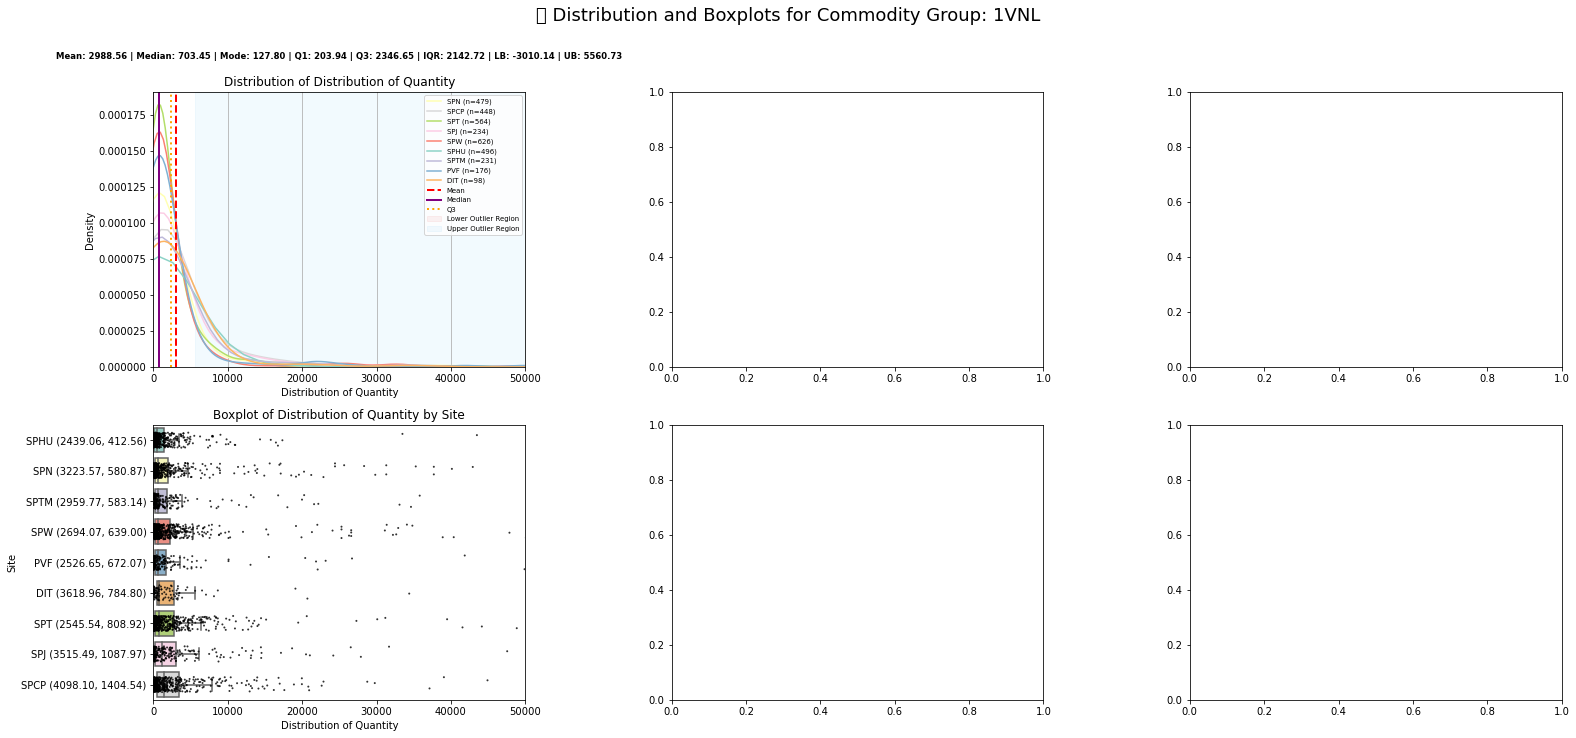

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


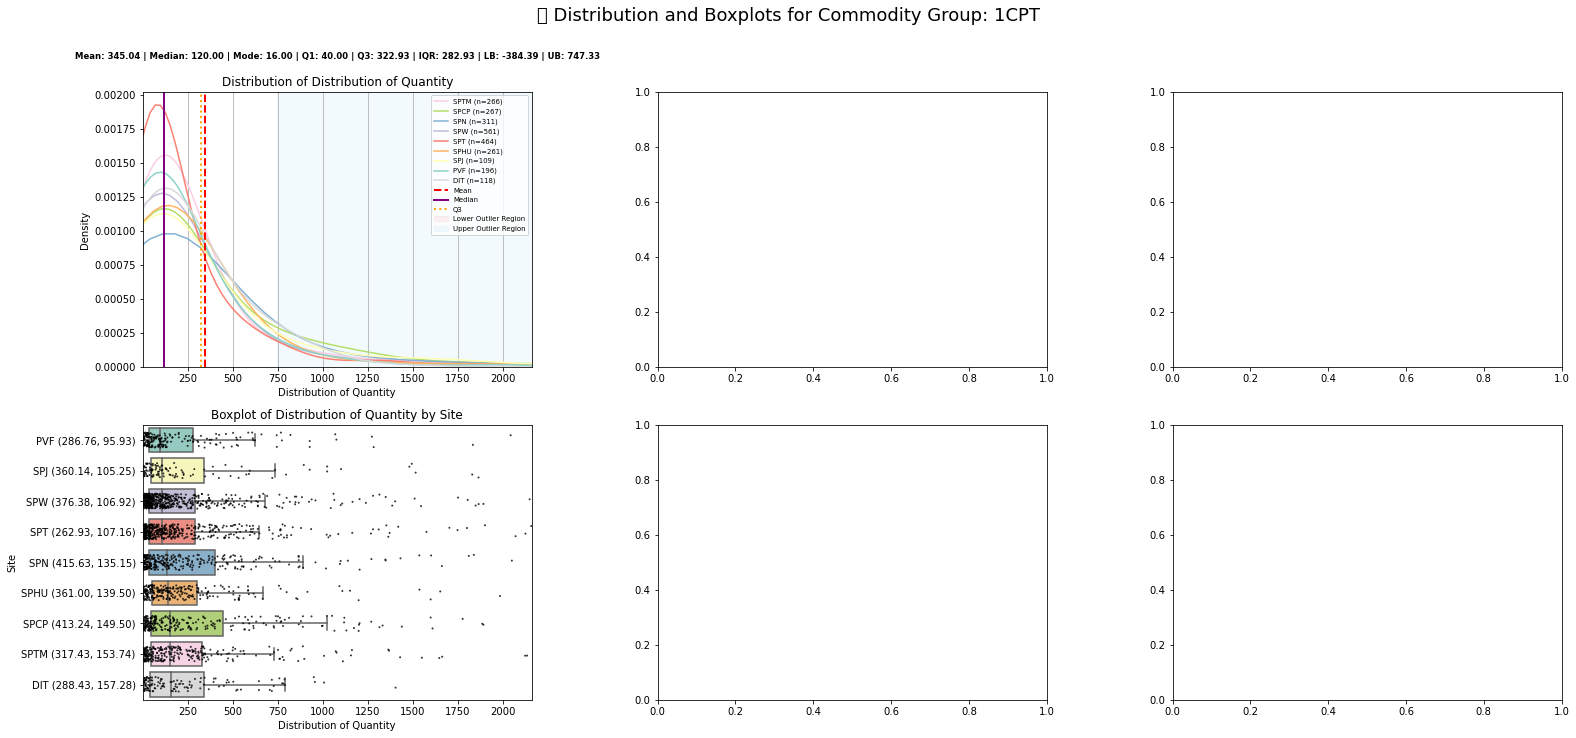

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


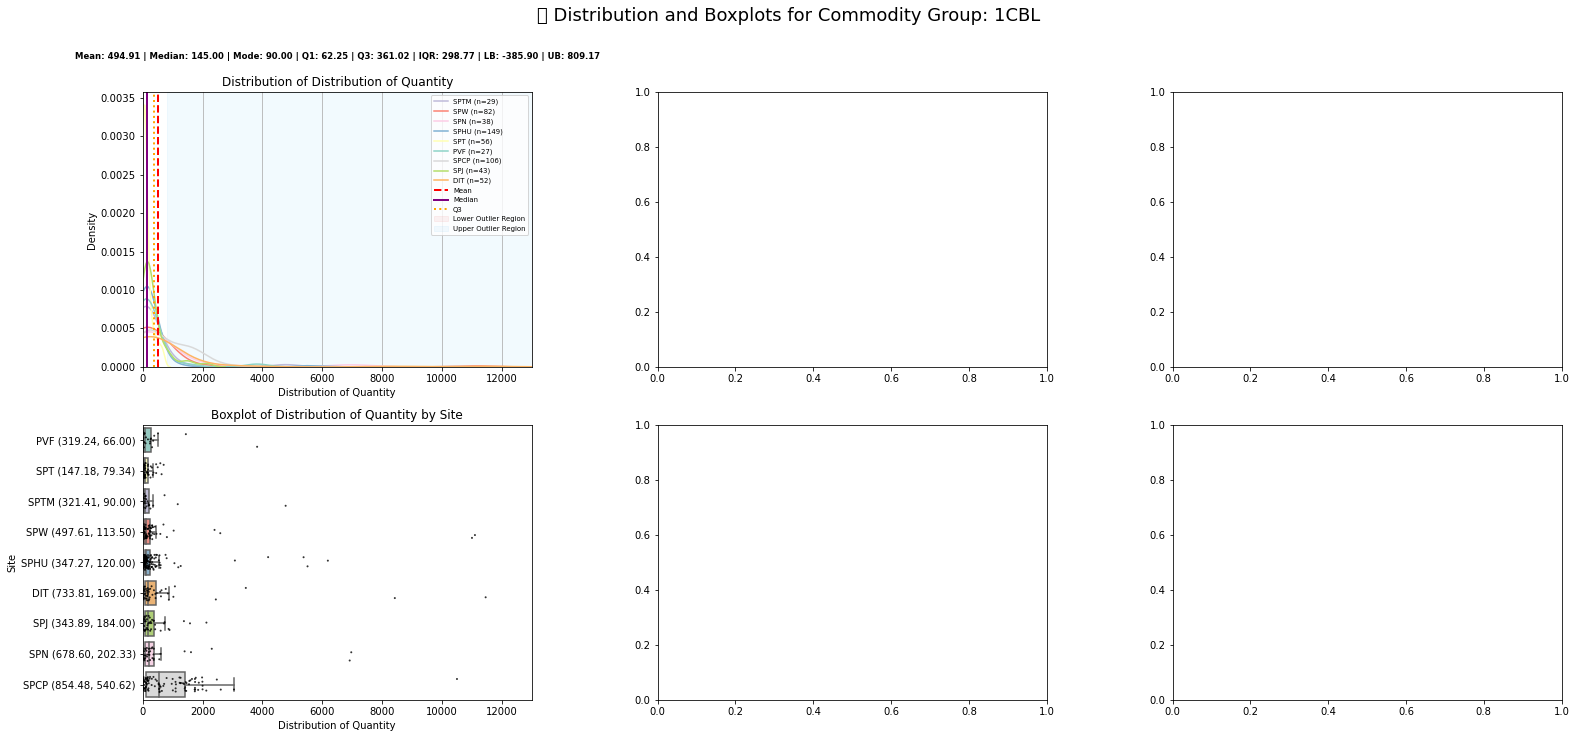

In [6]:
#df = df.drop_duplicates(subset='invoice_id', keep='first')
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)


# 📊 Define metrics and visuals
metrics = ["invoice_commodity_quantity",]
titles = ["Distribution of Quantity",]
colors = ["navy", "maroon", "steelblue", "darkorange"]

# 🔁 Loop by commodity group
commodity_groups = df['new_commodity_group'].dropna().unique()

for group in commodity_groups:
    group_df = df[df['new_commodity_group'] == group]

    # 🔁 Sort sites once by market_rate median
    market_sorted = (
        group_df.dropna(subset=["invoice_commodity_quantity", "site"])
        .groupby("site")["invoice_commodity_quantity"]
        .median()
        .sort_values()
        .index.tolist()
    )
    # 🎨 Assign fixed color per site for visual consistency
    site_palette = dict(zip(
    market_sorted,
    sns.color_palette("Set3", n_colors=len(market_sorted))
))

    fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    fig.subplots_adjust(hspace=0.75, wspace=0.3)
    fig.suptitle(f"📦 Distribution and Boxplots for Commodity Group: {group}", fontsize=18, y=1.02)

    for i, metric in enumerate(metrics):
        ax_top = axes[0, i]
        ax_bottom = axes[1, i]
        data = group_df[metric].dropna()

        # 📊 Summary statistics
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group_mean = data.mean()
        group_mode = data.mode().iloc[0] if not data.mode().empty else None

        # 🔢 Fixed or smart zoom per group
        group_str = str(group).strip().replace("[", "").replace("]", "").replace("'", "")
        if group_str == "1VNL":
            x_range = (0, 50000)
        elif group_str == "1CBL":
            x_range = (0, 13000)
        else:
            margin = 5 * iqr
            x_min = max(lower_bound - margin, data.min())
            x_max = min(upper_bound + margin, data.max())
            x_range = (x_min, x_max)

        # 📈 KDEs by site
        for site in group_df['site'].dropna().unique():
            site_subset = group_df[group_df['site'] == site]
            site_subset_valid = site_subset[site_subset[metric].notna()]
            site_data = site_subset_valid[metric]
            unique_invoices = site_subset_valid['invoice_id'].nunique()

            if len(site_data) > 1:
                sns.kdeplot(
    site_data,
    ax=ax_top,
    label=f"{site} (n={unique_invoices})",
    linewidth=1.5,
    color=site_palette.get(site, "gray")
)


        # 🔶 Shade outlier regions
        ax_top.axvspan(x_range[0], lower_bound, color='lightcoral', alpha=0.1, label='Lower Outlier Region')
        ax_top.axvspan(upper_bound, x_range[1], color='lightskyblue', alpha=0.1, label='Upper Outlier Region')

        # 📍 Vertical lines
        ax_top.axvline(group_mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(q2, color='purple', linestyle='-', linewidth=2, label='Median')
        ax_top.axvline(q3, color='orange', linestyle=':', linewidth=2, label='Q3')

        # 📝 Summary annotation
        stats_text = (
            f"Mean: {group_mean:.2f} | Median: {q2:.2f} | "
            f"Mode: {group_mode:.2f} | Q1: {q1:.2f} | Q3: {q3:.2f} | "
            f"IQR: {iqr:.2f} | LB: {lower_bound:.2f} | UB: {upper_bound:.2f}"
        )
        ax_top.text(
            0.5, 1.12, stats_text,
            transform=ax_top.transAxes,
            ha='center',
            fontsize=8.5,
            color='black',
            fontweight='bold'
        )

        # 📐 Apply axis range
        ax_top.set_xlim(x_range)
        ax_bottom.set_xlim(x_range)
        ax_top.set_title(f"Distribution of {titles[i]}")
        ax_top.set_xlabel(titles[i])
        ax_top.set_ylabel("Density")
        ax_top.grid(axis='y', visible=False)
        ax_top.grid(axis='x', visible=True)
        ax_top.legend(fontsize="x-small", loc='upper right')

        # 📦 Boxplot + Stripplot (consistent sorting by market_rate)
        plot_data = group_df.dropna(subset=[metric, "site"])
        # 🔁 Build axis labels with (median, mean)
        y_labels = []
        for site in market_sorted:
            site_data = group_df[group_df["site"] == site][metric].dropna()
            if site_data.empty:
                y_labels.append(site)
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()
            label = f"{site} ({mean_val:.2f}, {median_val:.2f})"
            y_labels.append(label)


        sns.boxplot(
            data=plot_data,
            x=metric,
            y="site",
            ax=ax_bottom,
            palette=site_palette,
            fliersize=0,
            order=market_sorted
        )

        sns.stripplot(
            data=plot_data,
            x=metric,
            y="site",
            dodge=True,
            jitter=0.25,
            alpha=0.8,
            size=2,
            
            #palette=site_palette,
            color='black',
            ax=ax_bottom,
            order=market_sorted,
        )
        # ➕ Add mean and median markers per site
        for idx, site in enumerate(market_sorted):
            site_data = plot_data[plot_data["site"] == site][metric]
            if site_data.empty:
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()

            # Horizontal markers: median = purple, mean = red
            ax_bottom.hlines(
                y=idx,
                xmin=median_val - 0.01,
                xmax=median_val + 0.01,
                color='purple',
                linewidth=3,
                label='Median' if idx == 0 else "",  # Only label once for legend
                zorder=5
            )
            ax_bottom.hlines(
                y=idx,
                xmin=mean_val - 0.01,
                xmax=mean_val + 0.01,
                color='red',
                linewidth=3,
                label='Mean' if idx == 0 else "",
                zorder=5
            )


        ax_bottom.set_title(f"Boxplot of {titles[i]} by Site")
        ax_bottom.set_xlabel(titles[i])
        ax_bottom.set_ylabel("Site")
        ax_bottom.legend([], [], frameon=False)

        # 🏷️ Set annotated Y-axis labels
        ax_bottom.set_yticks(range(len(y_labels)))
        ax_bottom.set_yticklabels(y_labels)

    plt.tight_layout()
    plt.show()


## Distribution of total freight costs

In [7]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


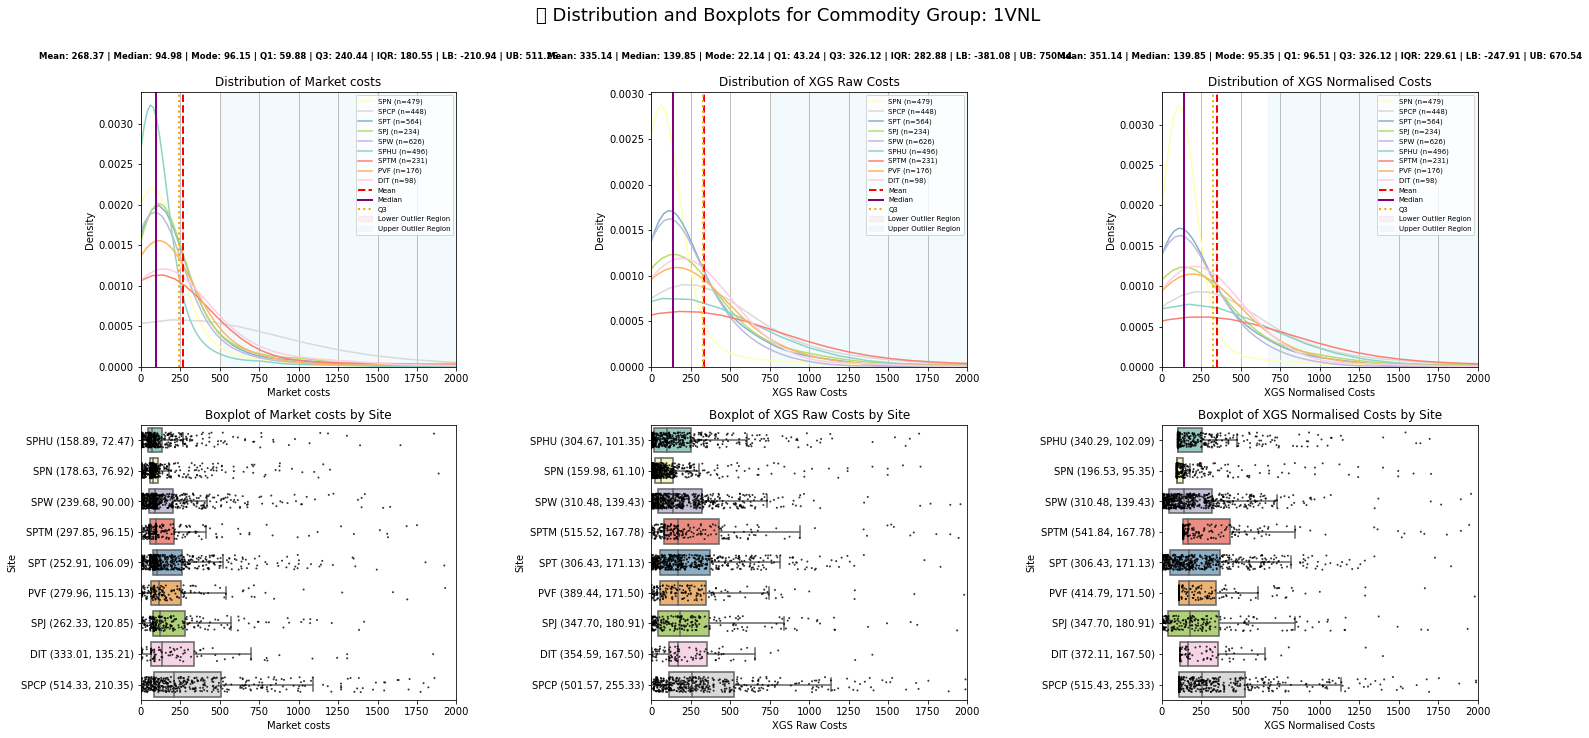

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


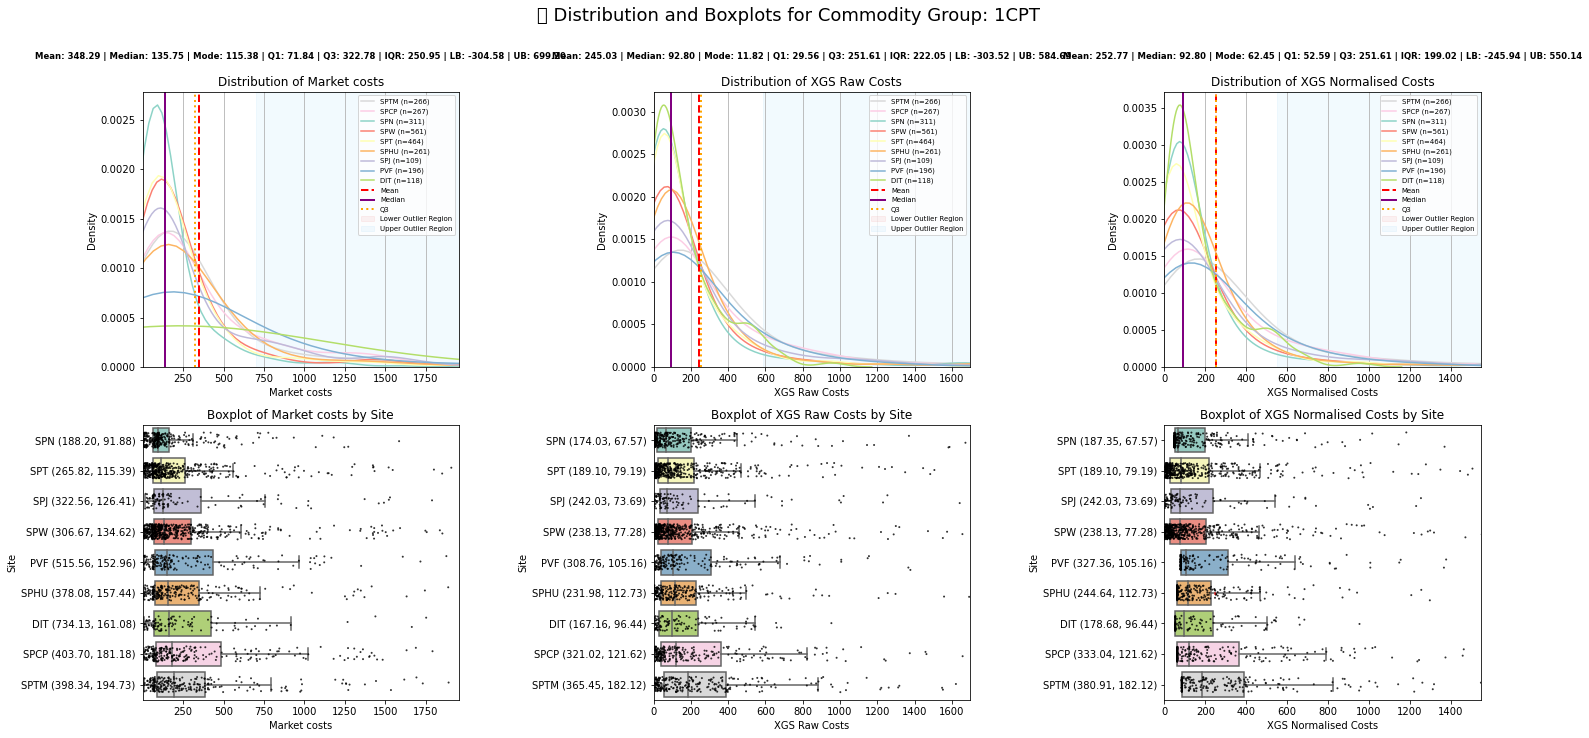

c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


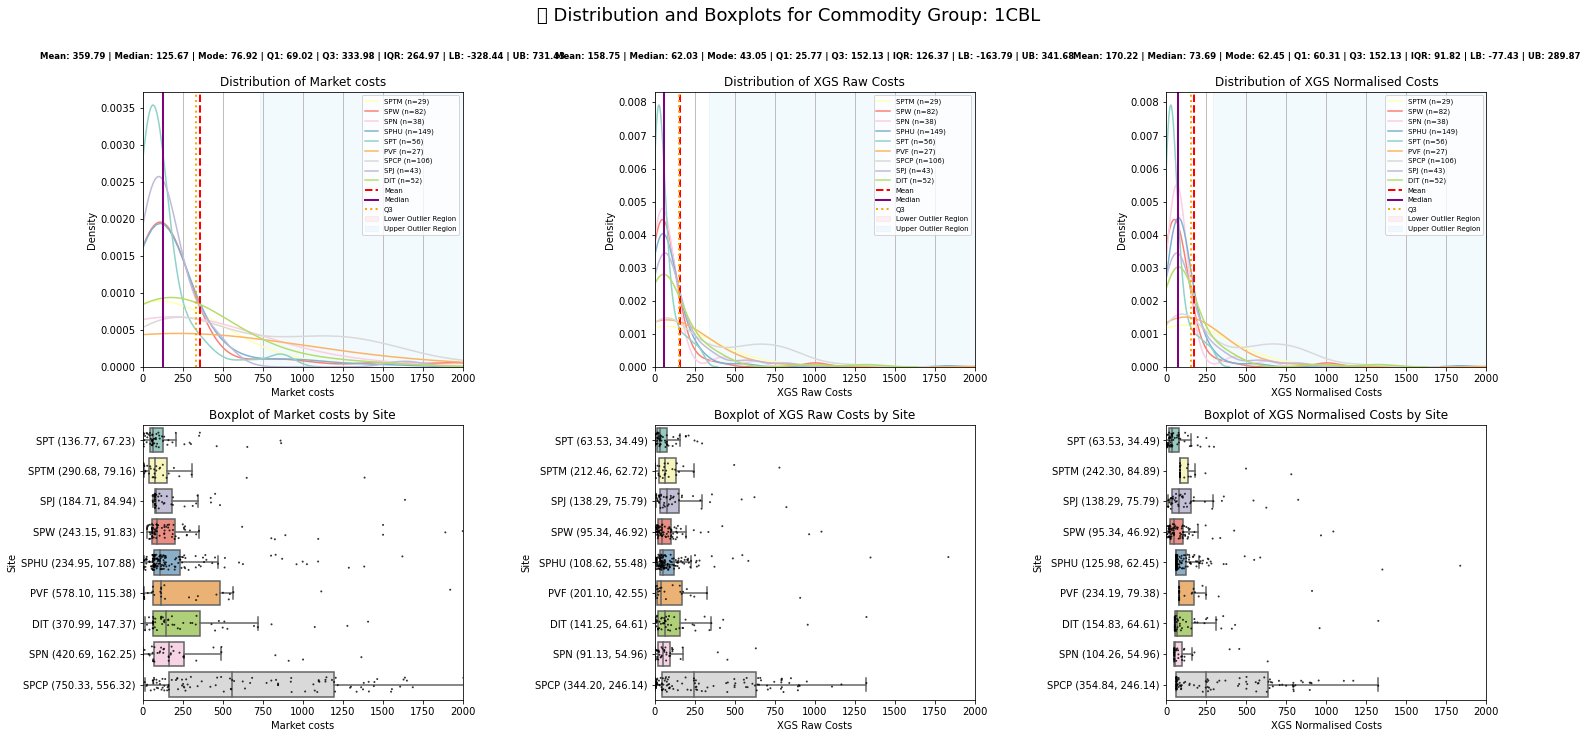

In [8]:
#df = df.drop_duplicates(subset='invoice_id', keep='first')
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)


# 📊 Define metrics and visuals
metrics = ['calibrated_market_freight_costs',"raw_invoice_cost",'invoice_freight_commodity_cost', ]
titles = ["Market costs","XGS Raw Costs","XGS Normalised Costs"]
colors = ["navy", "maroon", "steelblue", "darkorange"]

# 🔁 Loop by commodity group
commodity_groups = df['new_commodity_group'].dropna().unique()

for group in commodity_groups:
    group_df = df[df['new_commodity_group'] == group]

    # 🔁 Sort sites once by market_rate median
    market_sorted = (
        group_df.dropna(subset=["calibrated_market_freight_costs", "site"])
        .groupby("site")["calibrated_market_freight_costs"]
        .median()
        .sort_values()
        .index.tolist()
    )
    # 🎨 Assign fixed color per site for visual consistency
    site_palette = dict(zip(
    market_sorted,
    sns.color_palette("Set3", n_colors=len(market_sorted))
))

    fig, axes = plt.subplots(2, 3, figsize=(22, 10))
    fig.subplots_adjust(hspace=0.75, wspace=0.3)
    fig.suptitle(f"📦 Distribution and Boxplots for Commodity Group: {group}", fontsize=18, y=1.02)

    for i, metric in enumerate(metrics):
        ax_top = axes[0, i]
        ax_bottom = axes[1, i]
        data = group_df[metric].dropna()

        # 📊 Summary statistics
        q1 = data.quantile(0.25)
        q2 = data.median()
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        group_mean = data.mean()
        group_mode = data.mode().iloc[0] if not data.mode().empty else None

        # 🔢 Fixed or smart zoom per group
        group_str = str(group).strip().replace("[", "").replace("]", "").replace("'", "")
        if group_str == "1VNL":
            x_range = (0, 2000)
        elif group_str == "1CBL":
            x_range = (0, 2000)
        else:
            margin = 5 * iqr
            x_min = max(lower_bound - margin, data.min())
            x_max = min(upper_bound + margin, data.max())
            x_range = (x_min, x_max)

        # 📈 KDEs by site
        for site in group_df['site'].dropna().unique():
            site_subset = group_df[group_df['site'] == site]
            site_subset_valid = site_subset[site_subset[metric].notna()]
            site_data = site_subset_valid[metric]
            unique_invoices = site_subset_valid['invoice_id'].nunique()

            if len(site_data) > 1:
                sns.kdeplot(
    site_data,
    ax=ax_top,
    label=f"{site} (n={unique_invoices})",
    linewidth=1.5,
    color=site_palette.get(site, "gray")
)


        # 🔶 Shade outlier regions
        ax_top.axvspan(x_range[0], lower_bound, color='lightcoral', alpha=0.1, label='Lower Outlier Region')
        ax_top.axvspan(upper_bound, x_range[1], color='lightskyblue', alpha=0.1, label='Upper Outlier Region')

        # 📍 Vertical lines
        ax_top.axvline(group_mean, color='red', linestyle='--', linewidth=2, label='Mean')
        ax_top.axvline(q2, color='purple', linestyle='-', linewidth=2, label='Median')
        ax_top.axvline(q3, color='orange', linestyle=':', linewidth=2, label='Q3')

        # 📝 Summary annotation
        stats_text = (
            f"Mean: {group_mean:.2f} | Median: {q2:.2f} | "
            f"Mode: {group_mode:.2f} | Q1: {q1:.2f} | Q3: {q3:.2f} | "
            f"IQR: {iqr:.2f} | LB: {lower_bound:.2f} | UB: {upper_bound:.2f}"
        )
        ax_top.text(
            0.5, 1.12, stats_text,
            transform=ax_top.transAxes,
            ha='center',
            fontsize=8.5,
            color='black',
            fontweight='bold'
        )

        # 📐 Apply axis range
        ax_top.set_xlim(x_range)
        ax_bottom.set_xlim(x_range)
        ax_top.set_title(f"Distribution of {titles[i]}")
        ax_top.set_xlabel(titles[i])
        ax_top.set_ylabel("Density")
        ax_top.grid(axis='y', visible=False)
        ax_top.grid(axis='x', visible=True)
        ax_top.legend(fontsize="x-small", loc='upper right')

        # 📦 Boxplot + Stripplot (consistent sorting by market_rate)
        plot_data = group_df.dropna(subset=[metric, "site"])
        # 🔁 Build axis labels with (median, mean)
        y_labels = []
        for site in market_sorted:
            site_data = group_df[group_df["site"] == site][metric].dropna()
            if site_data.empty:
                y_labels.append(site)
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()
            label = f"{site} ({mean_val:.2f}, {median_val:.2f})"
            y_labels.append(label)


        sns.boxplot(
            data=plot_data,
            x=metric,
            y="site",
            ax=ax_bottom,
            palette=site_palette,
            fliersize=0,
            order=market_sorted
        )

        sns.stripplot(
            data=plot_data,
            x=metric,
            y="site",
            dodge=True,
            jitter=0.25,
            alpha=0.8,
            size=2,
            
            #palette=site_palette,
            color='black',
            ax=ax_bottom,
            order=market_sorted,
        )
        # ➕ Add mean and median markers per site
        for idx, site in enumerate(market_sorted):
            site_data = plot_data[plot_data["site"] == site][metric]
            if site_data.empty:
                continue
            median_val = site_data.median()
            mean_val = site_data.mean()

            # Horizontal markers: median = purple, mean = red
            ax_bottom.hlines(
                y=idx,
                xmin=median_val - 0.01,
                xmax=median_val + 0.01,
                color='purple',
                linewidth=3,
                label='Median' if idx == 0 else "",  # Only label once for legend
                zorder=5
            )
            ax_bottom.hlines(
                y=idx,
                xmin=mean_val - 0.01,
                xmax=mean_val + 0.01,
                color='red',
                linewidth=3,
                label='Mean' if idx == 0 else "",
                zorder=5
            )


        ax_bottom.set_title(f"Boxplot of {titles[i]} by Site")
        ax_bottom.set_xlabel(titles[i])
        ax_bottom.set_ylabel("Site")
        ax_bottom.legend([], [], frameon=False)

        # 🏷️ Set annotated Y-axis labels
        ax_bottom.set_yticks(range(len(y_labels)))
        ax_bottom.set_yticklabels(y_labels)

    plt.tight_layout()
    plt.show()


## Freight Costs

In [9]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

C:\Users\nzhuw\AppData\Local\Temp/ipykernel_3748/659039524.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


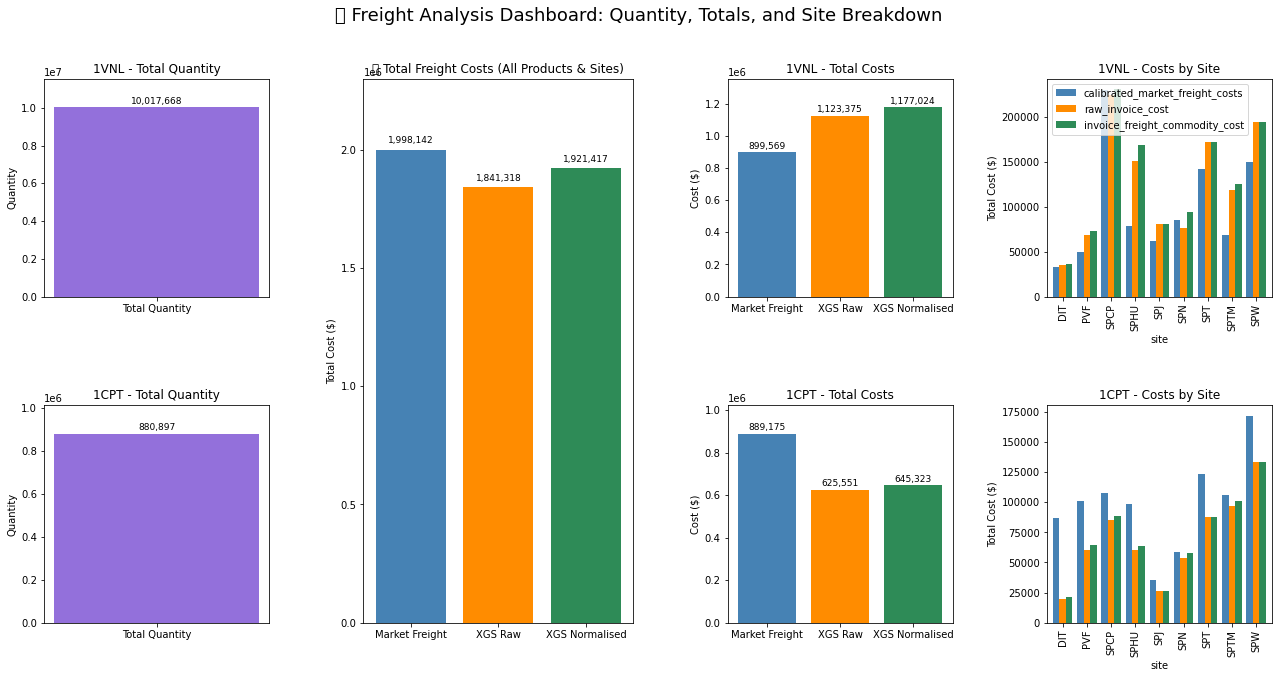

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get the first two unique product groups
product_groups = df['new_commodity_group'].dropna().unique()[:2]

# Setup custom grid layout
fig = plt.figure(figsize=(22, 10))
gs = gridspec.GridSpec(2, 4, width_ratios=[1, 1.2, 1, 1], wspace=0.4, hspace=0.5)

# --- Column 2: Grand Total Costs (All Products & Sites) ---
ax0 = fig.add_subplot(gs[:, 1])  # Span both rows
totals_all = [
    df['calibrated_market_freight_costs'].sum(),
    df['raw_invoice_cost'].sum(),
    df['invoice_freight_commodity_cost'].sum()
]
labels = ['Market Freight', 'XGS Raw', 'XGS Normalised']
colors = ['steelblue', 'darkorange', 'seagreen']
bars = ax0.bar(labels, totals_all, color=colors)
ax0.set_title('🧾 Total Freight Costs (All Products & Sites)')
ax0.set_ylabel('Total Cost ($)')
ax0.grid(False)

# Adjust y-axis and add labels
ymax = max(totals_all) * 1.15
ax0.set_ylim(0, ymax)
for bar in bars:
    yval = bar.get_height()
    ax0.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

# Per-product rows (columns 1, 3, 4)
for i, group in enumerate(product_groups):
    subset = df[df['new_commodity_group'] == group]

    # --- Column 1: Total Quantity ---
    ax1 = fig.add_subplot(gs[i, 0])
    total_quantity = subset['invoice_commodity_quantity'].sum()
    bars = ax1.bar(['Total Quantity'], [total_quantity], color='mediumpurple')
    ax1.set_title(f'{group} - Total Quantity')
    ax1.set_ylabel('Quantity')
    ax1.grid(False)

    ymax = total_quantity * 1.15
    ax1.set_ylim(0, ymax)
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

    # --- Column 3: Total Costs (Per Product) ---
    ax2 = fig.add_subplot(gs[i, 2])
    totals_product = [
        subset['calibrated_market_freight_costs'].sum(),
        subset['raw_invoice_cost'].sum(),
        subset['invoice_freight_commodity_cost'].sum()
    ]
    bars = ax2.bar(labels, totals_product, color=colors)
    ax2.set_title(f'{group} - Total Costs')
    ax2.set_ylabel('Cost ($)')
    ax2.grid(False)

    ymax = max(totals_product) * 1.15
    ax2.set_ylim(0, ymax)
    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

    # --- Column 4: Costs by Site ---
    ax3 = fig.add_subplot(gs[i, 3])
    site_grouped = subset.groupby('site')[[
        'calibrated_market_freight_costs',
        'raw_invoice_cost',
        'invoice_freight_commodity_cost'
    ]].sum().dropna()
    site_grouped.plot(
        kind='bar',
        ax=ax3,
        color=colors,
        width=0.8,
        legend=i == 0  # Only show legend on top row
    )
    ax3.set_title(f'{group} - Costs by Site')
    ax3.set_ylabel('Total Cost ($)')
    ax3.grid(False)

# Global title
plt.suptitle('📦 Freight Analysis Dashboard: Quantity, Totals, and Site Breakdown', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\nzhuw\AppData\Local\Temp/ipykernel_3748/3491145143.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 129534 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 129534 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\nzhuw\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 128230 missing from current font.
  font.set_text(s, 0, flags=flags)


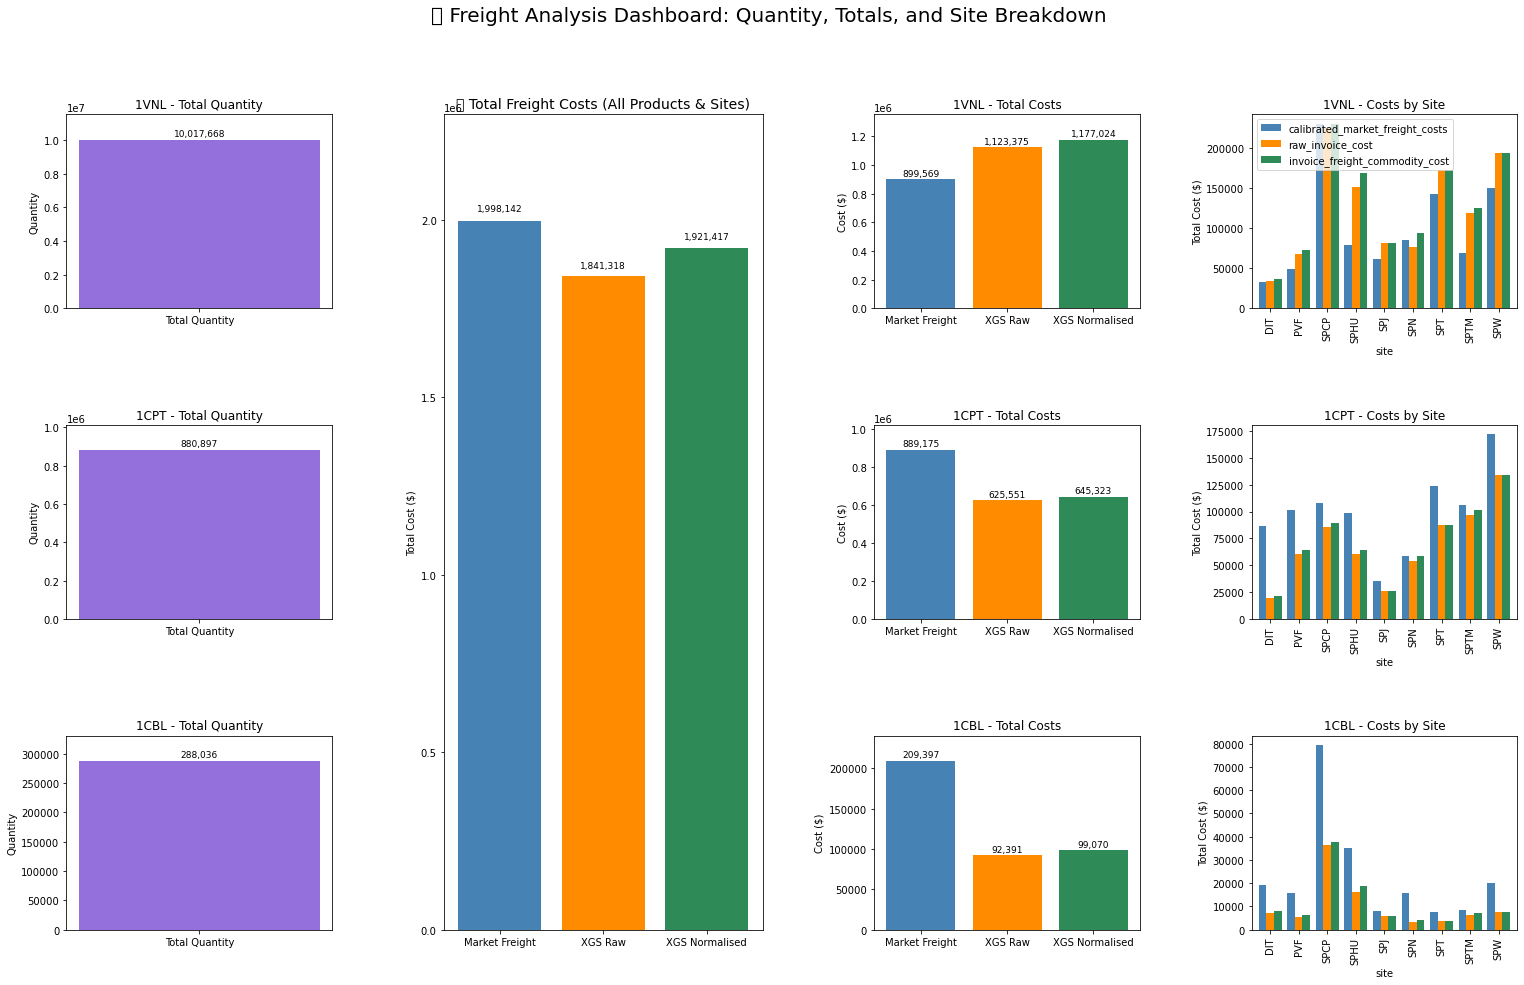

In [16]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Get the first three unique product groups
product_groups = df['new_commodity_group'].dropna().unique()[:3]

# Setup custom grid layout
fig = plt.figure(figsize=(26, 15))
gs = gridspec.GridSpec(3, 4, width_ratios=[1, 1.2, 1, 1], wspace=0.4, hspace=0.6)

# --- Column 2: Grand Total Costs (All Products & Sites) ---
ax0 = fig.add_subplot(gs[:, 1])  # Span all three rows
totals_all = [
    df['calibrated_market_freight_costs'].sum(),
    df['raw_invoice_cost'].sum(),
    df['invoice_freight_commodity_cost'].sum()
]
labels = ['Market Freight', 'XGS Raw', 'XGS Normalised']
colors = ['steelblue', 'darkorange', 'seagreen']
bars = ax0.bar(labels, totals_all, color=colors)
ax0.set_title('🧾 Total Freight Costs (All Products & Sites)', fontsize=14)
ax0.set_ylabel('Total Cost ($)')
ax0.grid(False)

# Adjust y-axis and add labels
ymax = max(totals_all) * 1.15
ax0.set_ylim(0, ymax)
for bar in bars:
    yval = bar.get_height()
    ax0.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

# Per-product rows (columns 1, 3, 4)
for i, group in enumerate(product_groups):
    subset = df[df['new_commodity_group'] == group]

    # --- Column 1: Total Quantity ---
    ax1 = fig.add_subplot(gs[i, 0])
    total_quantity = subset['invoice_commodity_quantity'].sum()
    bars = ax1.bar(['Total Quantity'], [total_quantity], color='mediumpurple')
    ax1.set_title(f'{group} - Total Quantity', fontsize=12)
    ax1.set_ylabel('Quantity')
    ax1.grid(False)

    ymax = total_quantity * 1.15
    ax1.set_ylim(0, ymax)
    for bar in bars:
        yval = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

    # --- Column 3: Total Costs (Per Product) ---
    ax2 = fig.add_subplot(gs[i, 2])
    totals_product = [
        subset['calibrated_market_freight_costs'].sum(),
        subset['raw_invoice_cost'].sum(),
        subset['invoice_freight_commodity_cost'].sum()
    ]
    bars = ax2.bar(labels, totals_product, color=colors)
    ax2.set_title(f'{group} - Total Costs', fontsize=12)
    ax2.set_ylabel('Cost ($)')
    ax2.grid(False)

    ymax = max(totals_product) * 1.15
    ax2.set_ylim(0, ymax)
    for bar in bars:
        yval = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, yval * 1.01, f'{yval:,.0f}', ha='center', va='bottom', fontsize=9)

    # --- Column 4: Costs by Site ---
    ax3 = fig.add_subplot(gs[i, 3])
    site_grouped = subset.groupby('site')[
        ['calibrated_market_freight_costs', 'raw_invoice_cost', 'invoice_freight_commodity_cost']
    ].sum().dropna()
    site_grouped.plot(
        kind='bar',
        ax=ax3,
        color=colors,
        width=0.8,
        legend=(i == 0)  # Only show legend on first group
    )
    ax3.set_title(f'{group} - Costs by Site', fontsize=12)
    ax3.set_ylabel('Total Cost ($)')
    ax3.grid(False)

# Global title
plt.suptitle('📦 Freight Analysis Dashboard: Quantity, Totals, and Site Breakdown', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## FTL/LTL analysis

In [19]:
df_filtered = df[df['freight_ratio_raw_outlier'] == 'NORMAL']

In [14]:
df.columns

Index(['invoice_id', 'site', 'new_commodity_group',
       'invoice_commodity_quantity', 'multiple_commodities',
       'priority_multiple_commodities', 'freight_per_invoice',
       'standardization_status', 'error_summary', 'priority_failure_reasons',
       'method', 'unit', 'rate_unit', 'freight_class', 'rate', 'shipment_type',
       'invoice_freight_commodity_cost', 'raw_invoice_cost', 'minimum_applied',
       'calibrated_market_freight_costs', 'market_rate', 'xgs_applied_rate',
       'xgs_raw_rate', 'freight_ratio_raw', 'freight_ratio_normal',
       'rate_ratio_raw', 'rate_ratio_normal', 'market_cost_outlier',
       'freight_ratio_raw_outlier', 'freight_ratio_normal_outlier'],
      dtype='object')

Valid cost types: ['calibrated_market_freight_costs' 'raw_invoice_cost'
 'invoice_freight_commodity_cost']


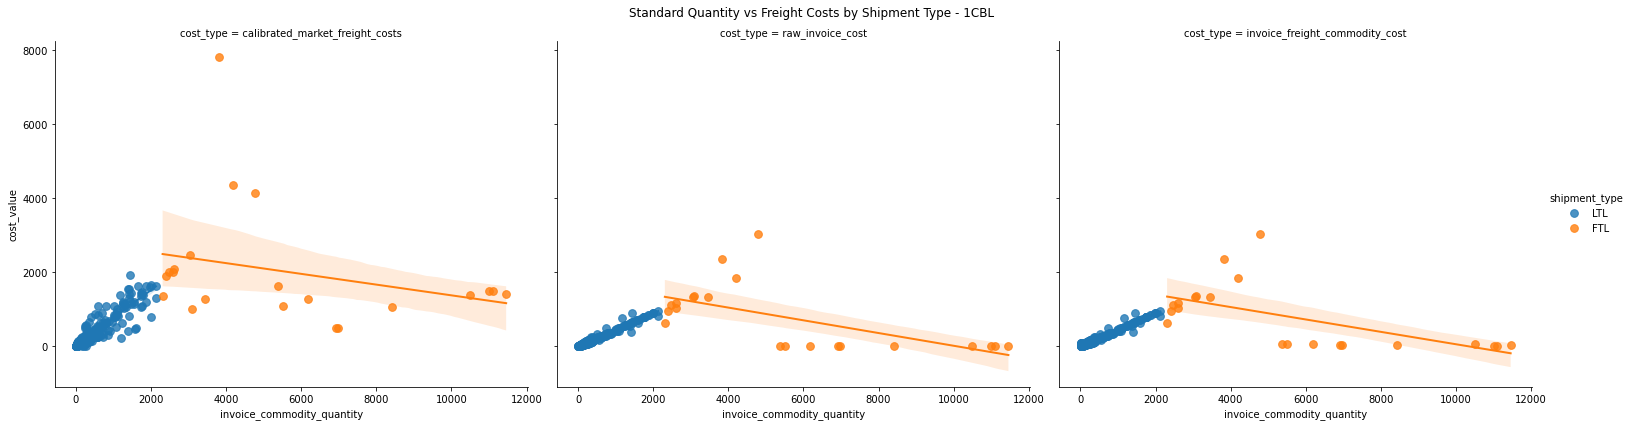

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for relevant commodity group
df2 = df_filtered[df_filtered['new_commodity_group'] == '1CBL'].copy()



# Melt the DataFrame to long format for multiple cost types
# Melt and drop rows with missing cost values
df_long = df2.melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=['calibrated_market_freight_costs','raw_invoice_cost', 'invoice_freight_commodity_cost'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])
print("Valid cost types:", df_long['cost_type'].unique())

# Plot multiple trend lines with X = standard_quantity, Y = cost_value
sns.lmplot(
    data=df_long,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    col='cost_type',
    height=6,
    aspect=1.2,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Standard Quantity vs Freight Costs by Shipment Type - 1CBL')
plt.show()


Valid cost types: ['calibrated_market_freight_costs' 'raw_invoice_cost'
 'invoice_freight_commodity_cost']


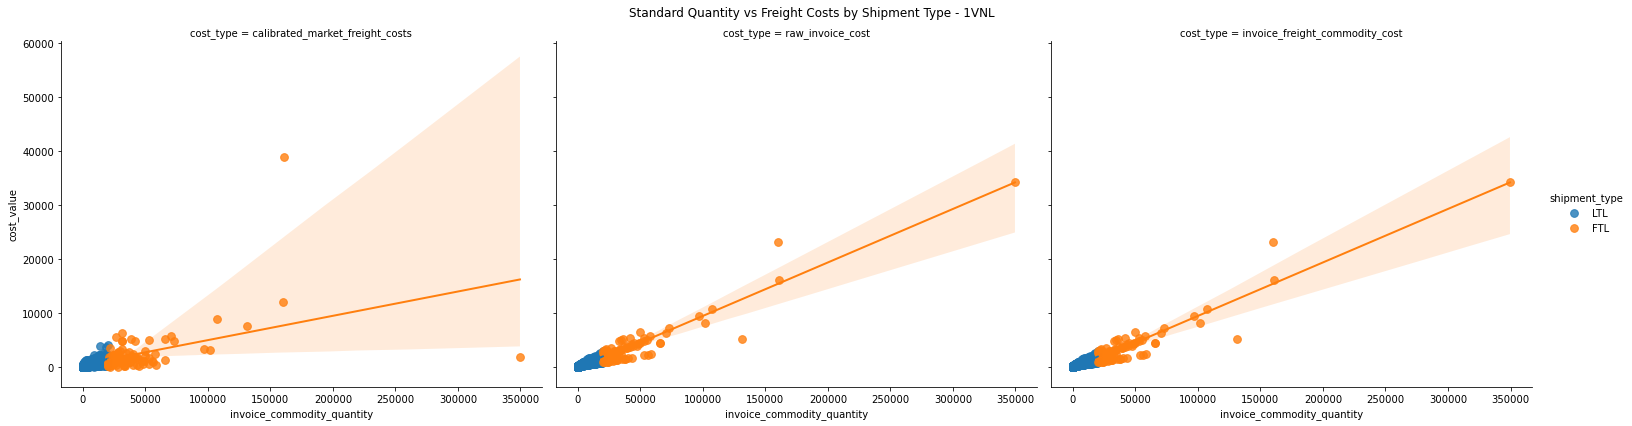

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for relevant commodity group
df2 = df_filtered[df_filtered['new_commodity_group'] == '1VNL'].copy()
#df2 = df2[df2['est_total_quantity'] < 100000]

# Melt the DataFrame to long format for multiple cost types
df_long = df2.melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=['calibrated_market_freight_costs','raw_invoice_cost', 'invoice_freight_commodity_cost'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])
print("Valid cost types:", df_long['cost_type'].unique())

# Plot multiple trend lines with X = standard_quantity, Y = cost_value
sns.lmplot(
    data=df_long,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    col='cost_type',
    height=6,
    aspect=1.2,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Standard Quantity vs Freight Costs by Shipment Type - 1VNL')
plt.show()


Valid cost types: ['calibrated_market_freight_costs' 'raw_invoice_cost'
 'invoice_freight_commodity_cost']


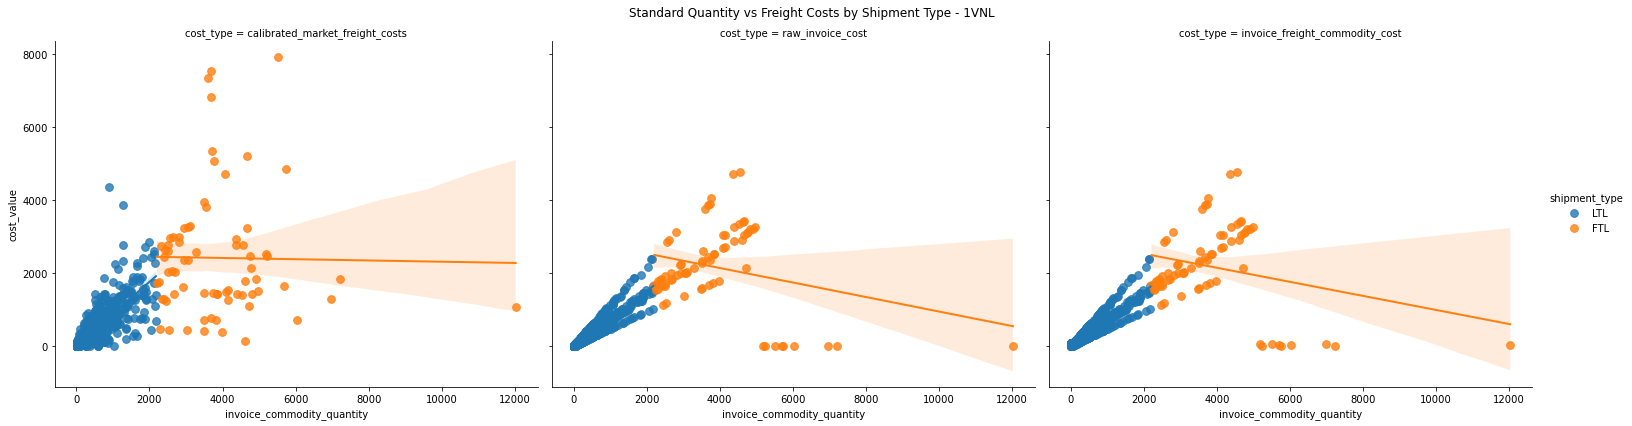

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for relevant commodity group
df2 = df_filtered[df_filtered['new_commodity_group'] == '1CPT'].copy()
#df2 = df2[df2['est_total_quantity'] < 100000]

# Melt the DataFrame to long format for multiple cost types
df_long = df2.melt(
    id_vars=['invoice_commodity_quantity', 'shipment_type'],
    value_vars=['calibrated_market_freight_costs','raw_invoice_cost', 'invoice_freight_commodity_cost'],
    var_name='cost_type',
    value_name='cost_value'
).dropna(subset=['cost_value'])
print("Valid cost types:", df_long['cost_type'].unique())

# Plot multiple trend lines with X = standard_quantity, Y = cost_value
sns.lmplot(
    data=df_long,
    x='invoice_commodity_quantity',
    y='cost_value',
    hue='shipment_type',
    col='cost_type',
    height=6,
    aspect=1.2,
    scatter_kws={'s': 60},
    line_kws={'linewidth': 2}
)

plt.subplots_adjust(top=0.9)
plt.suptitle('Standard Quantity vs Freight Costs by Shipment Type - 1VNL')
plt.show()
